In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import implicit

In [2]:
from implicit.datasets.movielens import get_movielens
from implicit.evaluation import leave_k_out_split

### CV

In [3]:
variant = "1m"

In [5]:
titles, ratings = get_movielens(variant)
ratings = ratings.T

In [19]:
col_names = ["user_id", "movie_id", "rating", "matrix_position"]
ratings_df = pd.read_csv('./ml-1m/ratings.dat', delimiter='::', names=col_names, engine='python')

In [17]:
def get_divided_test_fold(ratings_df, test_index, sampling_rate=.2):
    test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
    test_df = test_fold_df.groupby('user_id').sample(frac=.2)
    test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), 'rating'] = 0
    
    return test_fold_df, test_df

In [43]:
# divide ratings into 5 CV, still question about test data - see paper
# 0th column is 0, since user ids start with 1
from sklearn.model_selection import KFold
from implicit.evaluation import ndcg_at_k
from implicit.als import AlternatingLeastSquares

kf = KFold(n_splits=5, random_state=12345, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(ratings)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index.shape}")
    print(f"  Test:  index={test_index.shape}")
    
    # train data is divided into two parts
    # in train_index, full user data is used for training
    # in test_index, 80% of user data is used for training and the rest 20% is used for testing
    test_train_df, test_test_df = get_divided_test_fold(ratings_df, test_index)

    train_data = ratings.copy()
    # blend out the 20% of test users data for testing
    train_data[test_test_df.user_id, test_test_df.movie_id] = 0
    train_data = train_data

    # test data contains data used for training + blended out 20% 
    test_data = ratings[test_index,]

    model = AlternatingLeastSquares(factors=50, regularization=0.01)
    model.fit(train_data)

    ndcg = ndcg_at_k(model, train_data, test_data, K=10)
    print(f'ndcg: {ndcg}')




Fold 0:
  Train: index=(4832,)
  Test:  index=(1209,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1209 [00:00<?, ?it/s]

ndcg: 0.21876408181672088
Fold 1:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

ndcg: 0.23386000387795497
Fold 2:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

ndcg: 0.2339759194093315
Fold 3:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

ndcg: 0.22717859317484185
Fold 4:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

ndcg: 0.22609079030637397


In [23]:
test_test_df

,user_id,movie_id,rating,matrix_position
1435,13,2002,3,978202104
1360,13,2987,3,978202328
1392,13,2094,3,978202089
1460,13,1097,5,978201368
1415,13,2916,3,978201927
...,...,...,...,...
655590,3949,599,5,966213362
655630,3949,3508,5,965681579
655637,3949,2922,4,965681641
655646,3949,1210,3,965682008


#### Blending data in test fold 

In [163]:
test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
test_df = test_fold_df.groupby('user_id').sample(frac=.2)
test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), 'rating'] = 0

In [164]:
test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), :]

,user_id,movie_id,rating,matrix_position
236,4,1214,0,978294260
238,4,260,0,978294199
239,4,2028,0,978294230
241,4,1196,0,978294199
242,4,1198,0,978294199
...,...,...,...,...
997991,6029,3552,0,956721732
997995,6029,3584,0,956721732
997997,6029,3591,0,956721880
997998,6029,1210,0,956721594


In [165]:
test_df

,user_id,movie_id,rating,matrix_position
250,4,1201,5,978294230
238,4,260,5,978294199
247,4,2366,4,978294230
236,4,1214,4,978294260
317,5,2282,3,978244667
...,...,...,...,...
997998,6029,1210,3,956721594
997987,6029,3546,5,956721930
997974,6029,2409,2,956721594
997995,6029,3584,3,956721732


## User binnings

#### Age and gender

In [4]:
col_names = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv('./ml-1m/users.dat', delimiter='::', names=col_names, engine='python')

In [5]:
users.age.unique()

array([ 1, 56, 25, 45, 50, 35, 18])

In [52]:
age_bins = {}
age_bins[1] = '1-17'
age_bins[18] = '18-24'
age_bins[25] = '25-34'
age_bins[35] = '35-44'
age_bins[45] = '45-49'
age_bins[50] = '50-55'
age_bins[56] = '56+'

In [76]:
age_labels = list(age_bins.values())

<AxesSubplot: title={'center': 'Distribution of users per gender'}, xlabel='gender', ylabel='count'>

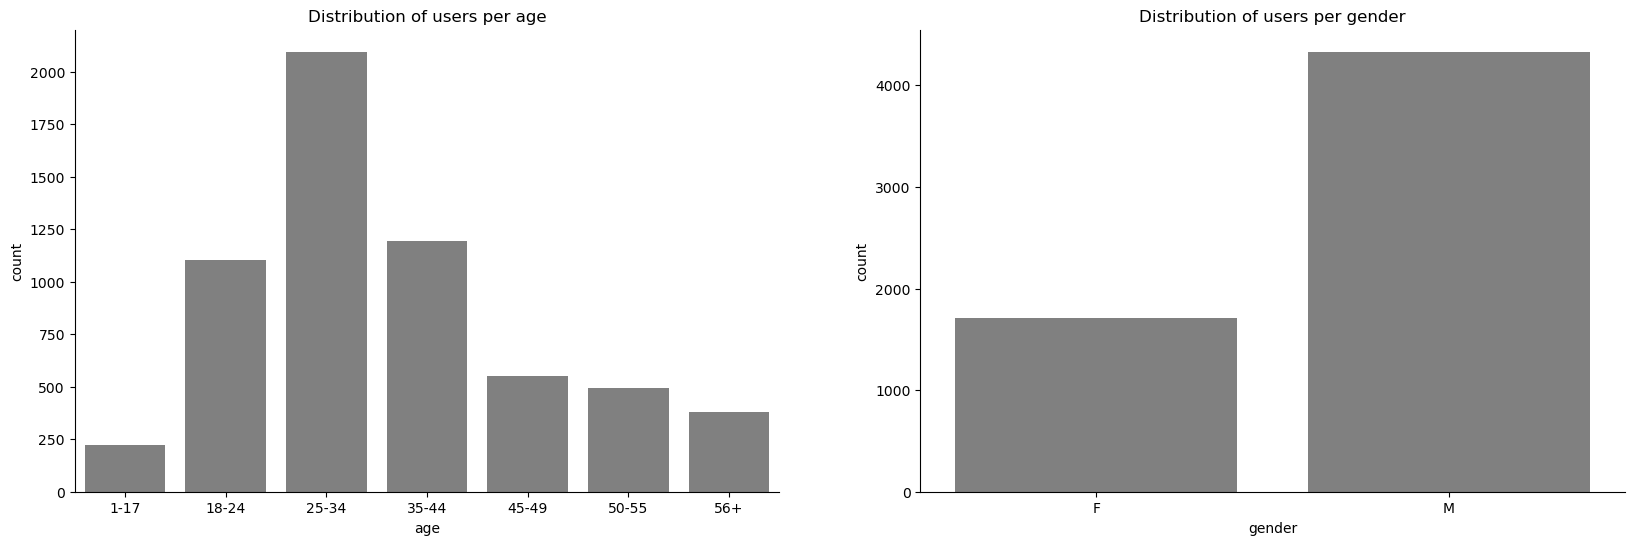

In [78]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per age')
sns.countplot(data=users, x='age', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('Distribution of users per gender')
sns.countplot(data=users, x='gender', color='grey', ax=ax[1])

In [30]:
for age in age_bins.keys():
    print(f'{age_bins[age]} bin')
    users_curr_age = users[users.age == age].index.values
    ratings_curr_age = ratings[:, users_curr_age]
    
    print('ratings shape: ', ratings_curr_age.shape)

1-17 bin
ratings shape:  (3953, 222)
18-24 bin
ratings shape:  (3953, 1103)
25-34 bin
ratings shape:  (3953, 2096)
35-44 bin
ratings shape:  (3953, 1193)
45-49 bin
ratings shape:  (3953, 550)
50-55 bin
ratings shape:  (3953, 496)
56+ bin
ratings shape:  (3953, 380)


#### Usage and pop-index

In [98]:
ratings.data = np.ones(len(ratings.data))
usage_vals = np.array(ratings.sum(axis=0)).flatten()[1:]

In [102]:
users

,user_id,gender,age,occupation,zip-code,usage
0,1,F,1,10,48067,53.0
1,2,M,56,16,70072,129.0
2,3,M,25,15,55117,51.0
3,4,M,45,7,02460,21.0
4,5,M,25,20,55455,198.0
...,...,...,...,...,...,...
6035,6036,F,25,15,32603,888.0
6036,6037,F,45,1,76006,202.0
6037,6038,F,56,1,14706,20.0
6038,6039,F,45,0,01060,123.0


In [99]:
usage_vals

array([ 53., 129.,  51., ...,  20., 123., 341.])

In [101]:
users['usage'] = usage_vals

<AxesSubplot: xlabel='usage', ylabel='Count'>

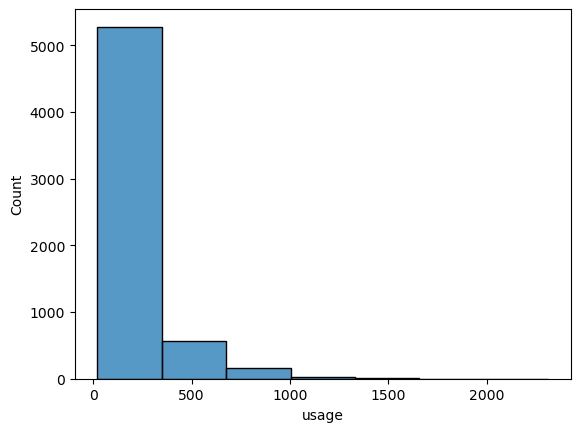

In [105]:
sns.histplot(users, x='usage', bins=7)

Questions to discuss:
- Binning by usage
- Split strategy for ML dataset
- WTF is pop-index and how to implement it